# Ronit Tsysar 316612803 | Guy Klinger 205413149 | Noa Kles 204938351 | Tal Meridor 313261257

## Python script stock price prediction using linear regression for later use in markovich model

### markovich() function explained:
    Gets the desired stocks to predict upon, as well as test size and amount 
    of portfolios to run. for each stock, call price_forecast() in order to run 
    linear regression and get predicted price. Then, calculate annual return 
    and covariance matrix for all of the stocks. As learned in class, 
    markovich model strength is in its ability to consider the variance of each 
    pair or group of stocks in order to get a  better, safer portfolio. For 
    each stock give random weight in each simulation, calculate, sharpe ration, 
    return and vollatility (risk). Finally, plot the efficiency frontier of all 
    the portfolios calculated and mark the safest one, the one eith the highest 
    sharp ratio and the one with the highest risk.


### price_forecast() function explained:
    Gets stock name, relevant dates and test size. After downloading stock's 
    data from yfinance, 4 different features are selected. data is then split 
    into train and test sets, inserted in a linear regression model for training
    and prediction. the prediction received from the model are returned to 
    markovich  function for portfolio analysis.



In [4]:
def price_forecast(stock, start_date, end_date, record_percentage_to_predict):
    """
    
    """
    df = yf.download(stock, start=start_date, end=end_date)

    df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
    df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Adj Close', 'HL_PCT', 'PCT_change', 'Volume']]

    forecast_col = 'Adj Close'
    # forecast_col = 'Adj. Close'
    df.fillna(value=-99999, inplace=True)
    forecast_out = int(math.ceil(record_percentage_to_predict * len(df)))
    df['label'] = df[forecast_col].shift(-forecast_out)
    print(df.head())
    # df['Adj Close'].plot()

    X = np.array(df.drop(['label'], 1))
    X = preprocessing.scale(X)
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]
    df.dropna(inplace=True)

    y = np.array(df['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=record_percentage_to_predict)
    # clf =  svm.SVR() # #LinearRegression()
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(confidence)
    forecast_set = clf.predict(X_lately)
    df['Forecast'] = np.nan

    last_date = df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day

    for i in forecast_set:
        next_date = datetime.datetime.fromtimestamp(next_unix)
        next_unix += 86400
        df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

    # df['Adj Close'].plot()
    # df['Forecast'].plot()
    # plt.legend(loc=4)
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.show()

    col = df['Forecast']
    col = col.dropna()
    return col

## Applying Markovich model

In [5]:
def markovich(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict):

    yf.pdr_override()
    frame = {}
    for stock in selected:
        # call price_forecast on each stock and get prediction for it's prices
        price = price_forecast(stock, start_date, end_date, record_percentage_to_predict)
        frame[stock] = price

    table = pd.DataFrame(frame)
    plt.plot(pd.DataFrame(frame))
    pd.DataFrame(frame).to_csv('Out.csv')

    returns_daily = table.pct_change()
    returns_daily.to_csv('Out1.csv')
    returns_annual = ((1 + returns_daily.mean()) ** 254) - 1
    returns_annual.to_csv('Out2.csv')

    # get daily and covariance of returns of the stock
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 254

    # empty lists to store returns, volatility and weights of imiginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = Num_porSimulation  # Change porfolio numbers here

    # set random seed for reproduction's sake
    np.random.seed(101)

    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns * 100)
        port_volatility.append(volatility * 100)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]

    # reorder dataframe columns
    df = df[column_order]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    # min_volatility1 = df['Volatility'].min()+1
    max_sharpe = df['Sharpe Ratio'].max()
    max_return = df['Returns'].max()
    max_vol = df['Volatility'].max()
    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    max_returns = df.loc[df['Returns'] == max_return]
    max_vols = df.loc[df['Volatility'] == max_vol]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='orange', marker='D', s=200)
    plt.scatter(x=max_vols['Volatility'], y=max_returns['Returns'], c='red', marker='D', s=200)
    plt.style.use('seaborn-dark')

    plt.xlabel('Volatility (Std. Deviation) Percentage %')
    plt.ylabel('Expected Returns Percentage %')
    plt.title('Efficient Frontier')
    plt.subplots_adjust(bottom=0.4)
    # ------------------ Pritning 3 optimal Protfolios -----------------------
    # Setting max_X, max_Y to act as relative border for window size

    red_num = df.index[df["Returns"] == max_return]
    yellow_num = df.index[df['Volatility'] == min_volatility]
    green_num = df.index[df['Sharpe Ratio'] == max_sharpe]
    multseries = pd.Series([1, 1, 1] + [100 for stock in selected],
                           index=['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected])
    with pd.option_context('display.float_format', '%{:,.2f}'.format):
        plt.figtext(0.2, 0.15, "Max returns Porfolio: \n" + df.loc[red_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='red', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.45, 0.15, "Safest Portfolio: \n" + df.loc[yellow_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.7, 0.15, "Sharpe  Portfolio: \n" + df.loc[green_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='green', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
    plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed
             Adj Close    HL_PCT  PCT_change     Volume       label
Date                                                               
2008-01-02  108.455856  2.161524   -1.091931  204935600  111.645691
2008-01-03  108.403450  0.985631   -0.034506  125133300  109.140511
2008-01-04  105.746872  1.795471   -1.416212  232330900  109.981087
2008-01-07  105.657036  1.520335   -0.437201  234991000  108.217560
2008-01-08  103.950867  3.221606   -2.231136  326365700  108.761452
0.8763712541000406


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues 

[*********************100%***********************]  1 of 1 completed
            Adj Close    HL_PCT  PCT_change     Volume      label
Date                                                             
2008-01-02  44.299950  2.673050   -1.677395  152344100  58.315979
2008-01-03  44.484497  1.216345    0.416582  114103700  56.864647
2008-01-04  42.533585  3.360304   -2.830756  212617600  57.463318
2008-01-07  42.331451  2.466789   -0.475214  235083600  56.356701
2008-01-08  41.232964  3.921569   -2.796773  261669800  56.710445
0.8623107785520167


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value i

[*********************100%***********************]  1 of 1 completed
            Adj Close    HL_PCT  PCT_change  Volume       label
Date                                                           
2008-01-02  83.646523  0.701959    0.388033   56600  107.362541
2008-01-03  83.772690  0.330499    0.188630   10200  107.449997
2008-01-04  84.056580  0.187791    0.037535   65300  107.318825
2008-01-07  84.143326  0.215938    0.150175   41100  107.519997
2008-01-08  84.206398  0.356980    0.178255   27900  107.458786
0.671880035981553


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value i

[*********************100%***********************]  1 of 1 completed
            Adj Close    HL_PCT  PCT_change  Volume      label
Date                                                          
2008-01-02  60.792934  1.104134    0.445035  728300  83.585693
2008-01-03  60.592361  0.645407    0.351180  151300  83.714493
2008-01-04  61.090908  0.528050    0.291653  135900  83.650078
2008-01-07  61.016441  0.432940   -0.075084  148300  83.864807
2008-01-08  60.901829  0.584963   -0.253430  127100  83.950737
0.7624849495603241


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value i

[*********************100%***********************]  1 of 1 completed
             Adj Close     HL_PCT  PCT_change    Volume        label
Date                                                                
2014-09-17  457.334015   3.481708   -1.831006  21056800  1255.150024
2014-09-18  424.440002  10.592001   -7.096262  34483200  1267.119995
2014-09-19  394.795990  11.261215   -6.910351  37919700  1272.829956
2014-09-20  408.903992   8.570006    3.605767  36863600  1223.540039
2014-09-21  398.821014   4.894691   -2.270110  26580100  1150.000000
0.327492364938476


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues 

[*********************100%***********************]  1 of 1 completed
            Adj Close    HL_PCT  PCT_change    Volume       label
Date                                                             
2008-01-02  84.860001  2.037388    1.555772  12291100  155.970001
2008-01-03  85.570000  1.583929    0.824787   9553900  152.020004
2008-01-04  85.129997  1.326546   -0.246073   8402200  152.639999
2008-01-07  84.769997  0.815895   -0.551386   6944300  153.759995
2008-01-08  86.779999  1.125805    0.579509   9567900  152.619995
0.1728992806681714


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value i

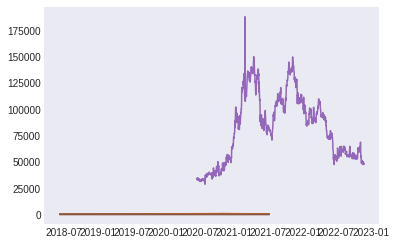

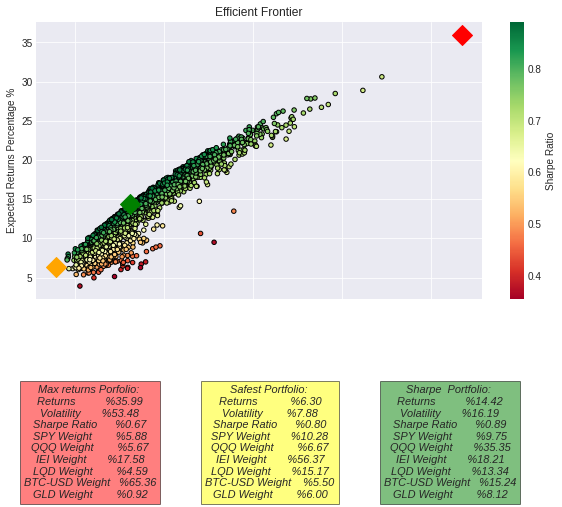

In [6]:
!pip install yfinance
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime

selected = ["SPY", "QQQ", "IEI", "LQD", "BTC-USD","GLD"]
record_percentage_to_predict = 0.3
markovich("2008-01-01", "2022-11-28", 2000, selected, record_percentage_to_predict)